# Extract data from Continuous-Drug Combination DataBase

Note: Requires internet connection to download information from the [C-DCDB](https://icc.ise.bgu.ac.il/medical_ai/CDCDB/).

Additionally, this notebook can also be used to reconcile DrugBank and PubChem IDs that are found.

## Setup
### Import packages

In [1]:
from collections import defaultdict
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    ROOT_PATH,
    DATABASE_PATH,
    ANNOTATION_PATH,
    INTERIM_PATH,
    GEM_NAME,
    read_rbc_model,
    get_annotation_df,
    compare_tables,
    visualize_comparison,
    show_versions,
    split_string,
    build_string,
)
from rbc_gem_utils.database import CDCDB_PATH, CDCDB_DB_TAG
from rbc_gem_utils.util import explode_column

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM model

In [2]:
model = read_rbc_model(filetype="xml")
model

Name,RBC_GEM
Memory address,145773990
Number of metabolites,1984
Number of reactions,2823
Number of genes,693
Number of groups,76
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


#### Load annotations

In [3]:
annotation_type = "genes"
df_model_mappings = get_annotation_df(
    getattr(model, annotation_type), ["drugbank", "pubchem.compound"]
).rename({"id": annotation_type}, axis=1)
for col in df_model_mappings.columns:
    df = (
        df_model_mappings[col]
        .apply(lambda x: split_string(x))
        .explode(col)
        .drop_duplicates()
    )
    print(f"{df.name}: {df.nunique()}")

drugbank_ids = (
    explode_column(df_model_mappings, "drugbank")["drugbank"].dropna().unique()
)
pubchem_ids = (
    explode_column(df_model_mappings, "pubchem.compound")["pubchem.compound"]
    .dropna()
    .unique()
)
df_model_mappings

genes: 693
drugbank: 2083
pubchem.compound: 1156


,genes,drugbank,pubchem.compound
0,RPE,DB00153,5280793
1,RPIA,DB01756,NaN
2,SORD,DB00157;DB04478,NaN
3,AKR7A2,NaN,NaN
4,SRM,DB00118,34755
...,...,...,...
688,SLC9B2,NaN,NaN
689,SMPD1,DB00381;DB00477;DB01151;DB12151;DB14009,2162;2726;2995;483477;60496;6435922;65327
690,SPHK1,DB08868,107969;107970
691,TRPC6,NaN,NaN


### Load C-DCDB data and identify combinations

In [4]:
database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
compare = True
display_nunique = True
overwrite = True

In [5]:
df_database_simplified = pd.read_csv(
    f"{ROOT_PATH}{DATABASE_PATH}{CDCDB_PATH}/web_preview.csv", index_col=0, dtype=str
)
df_database_simplified = df_database_simplified.reset_index(drop=False)
# Space left here if additional metadata needs to be added

df_combinations = df_database_simplified.copy().fillna("")
df_combinations["drugs"] = df_combinations["drugs"].apply(
    lambda x: sorted(x.split(","))
)
df_combinations["drugbank_identifiers"] = df_combinations["drugbank_identifiers"].apply(
    lambda x: x.split(";")
)
df_combinations["pubchem_identifiers"] = df_combinations["pubchem_identifiers"].apply(
    lambda x: [s.lstrip("CID") for s in x.split(";")]
)
df_combinations

,drugs,drugbank_identifiers,pubchem_identifiers,source_id,source
0,"[Foscarnet, Ganciclovir]","[DB01004, DB00529]","[NA, NA]",NCT00000134,clinicaltrials.gov
1,"[Foscarnet, Ganciclovir]","[DB00529, DB01004]","[NA, NA]",NCT00000136,clinicaltrials.gov
2,"[Clozapine, Cycloserine]","[DB00363, DB00260]","[2818, 6234]",NCT00000372,clinicaltrials.gov
3,"[Alendronic acid, Teriparatide]","[DB00630, DB06285]","[2088, 16133850]",NCT00000400,clinicaltrials.gov
4,"[Naltrexone, Sertraline]","[DB00704, DB01104]","[5360515, 68617]",NCT00000451,clinicaltrials.gov
...,...,...,...,...,...
41208,"[Desogestrel, Ethinylestradiol]","[DB00304, DB00977]","[40973, 5991]",,orangebook
41209,"[Ethinylestradiol, Norgestimate]","[DB00977, DB00957]","[5991, 6540478]",,orangebook
41210,"[Ethinylestradiol, Ferrous fumarate, Norethist...","[DB00977, DB14491, DB00717]","[5991, 6433164, NA]",,orangebook
41211,"[Ethinylestradiol, Ferrous fumarate, Norethist...","[DB00977, DB14491, DB00717]","[5991, 6433164, 6230]",,orangebook


In [6]:
df_alias_mapping = df_combinations.loc[
    :, ["drugbank_identifiers", "pubchem_identifiers"]
].explode(["drugbank_identifiers", "pubchem_identifiers"])
df_alias_mapping = (
    df_alias_mapping.replace("NA", float("nan"))
    .drop_duplicates()
    .reset_index(drop=True)
)
df_alias_mapping = (
    df_alias_mapping.rename(
        {"drugbank_identifiers": "drugbank", "pubchem_identifiers": "pubchem.compound"},
        axis=1,
    )
    .dropna()
    .reset_index(drop=True)
)
if overwrite:
    df_alias_mapping.to_csv(f"{database_dirpath}{CDCDB_PATH}/aliases.tsv", sep="\t")
df_alias_mapping

,drugbank,pubchem.compound
0,DB00363,2818
1,DB00260,6234
2,DB00630,2088
3,DB06285,16133850
4,DB00704,5360515
...,...,...
3252,DB01501,34328
3253,DB00233,2724368
3254,DB00790,12068809
3255,DB00823,9270


#### Extract as model annotations

genes: 422
drugbank: 2101
pubchem.compound: 1158


,genes,drugbank,pubchem.compound
0,AARS1,DB00160,
1,ABCA1,DB00163;DB00171;DB00675;DB01016;DB01599;DB11635,14985;2733525;2733526;3488;4912;5957
2,ABCB1,DB00027;DB00052;DB00080;DB00091;DB00104;DB0017...,10034073;10077129;10077130;10096344;10113978;1...
3,ABCB4,DB06207;DB06414,193962;5312125
4,ABCC1,DB00115;DB00143;DB00171;DB00224;DB00286;DB0032...,10608;107969;107970;11243969;123596;124886;126...
...,...,...,...
417,VDAC1,DB01375;DB09061;DB14009;DB14011,44148067;644019
418,VDAC2,DB01375;DB06098,
419,VDAC3,DB01375;DB06098,
420,WARS1,DB00150;DB01831;DB04537,6305


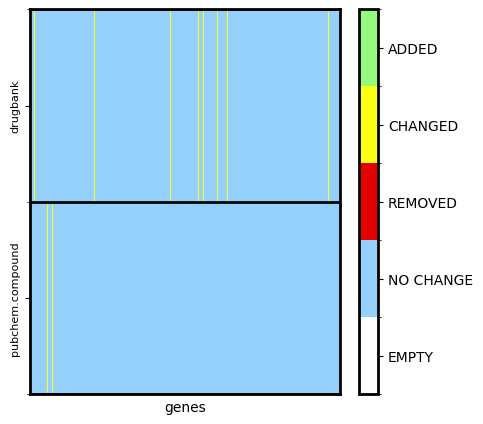

In [7]:
annotation_type = "genes"
# Format as model annotations
df_model_drugs = (
    df_model_mappings.set_index(annotation_type)["drugbank"]
    .apply(split_string)
    .explode()
    .dropna()
    .reset_index()
)
df_annotations = df_model_drugs.merge(
    df_alias_mapping, left_on="drugbank", right_on="drugbank", how="left"
)
df_model_drugs = (
    df_model_mappings.set_index(annotation_type)["pubchem.compound"]
    .apply(split_string)
    .explode()
    .dropna()
    .reset_index()
)

df_annotations = pd.concat(
    (
        df_annotations,
        df_model_drugs.merge(
            df_alias_mapping,
            left_on="pubchem.compound",
            right_on="pubchem.compound",
            how="left",
        ),
    ),
    axis=0,
)
df_annotations["pubchem.compound"] = df_annotations["pubchem.compound"].str.lstrip(
    "CID"
)
df_annotations = df_annotations.groupby(annotation_type, as_index=False).agg(
    lambda x: build_string(sorted(x.dropna().unique()))
)


if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{CDCDB_DB_TAG}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type])
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{CDCDB_DB_TAG}.tsv", sep="\t"
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{CDCDB_DB_TAG}.tsv", sep="\t"
    )

df_annotations

### Map against model

In [8]:
# TODO deal with combinations that have NA in the identifier
# TODO deal with PubChem compounds
indicies_to_keep = sorted(
    set(
        [
            idx
            for idx, row in df_combinations["drugbank_identifiers"].dropna().items()
            if not set(row).difference(set(drugbank_ids))
        ]
    )
    # .union([
    #     idx
    #     for idx, row in df_combinations["pubchem_identifiers"].dropna().items()
    #     if not set(row).difference(set(pubchem_ids))
)

df_model_combinations = df_combinations.loc[indicies_to_keep].reset_index(drop=True)
df_model_combinations

,drugs,drugbank_identifiers,pubchem_identifiers,source_id,source
0,"[Foscarnet, Ganciclovir]","[DB01004, DB00529]","[NA, NA]",NCT00000134,clinicaltrials.gov
1,"[Foscarnet, Ganciclovir]","[DB00529, DB01004]","[NA, NA]",NCT00000136,clinicaltrials.gov
2,"[Aldesleukin, Artesunate]","[DB00041, DB09274]","[NA, 6917864]",NCT00000948,clinicaltrials.gov
3,"[Estradiol, Progesterone]","[DB00396, DB00783]","[5994, 5757]",NCT00001481,clinicaltrials.gov
4,"[Flutamide, Hydrocortisone, Letrozole]","[DB00499, DB01006, DB00741]","[3397, 3902, 5754]",NCT00001521,clinicaltrials.gov
...,...,...,...,...,...
9417,"[Elbasvir, Grazoprevir]","[DB11574, DB11575]","[71661251, 44603531]",,orangebook
9418,"[Ethinylestradiol, Norgestimate]","[DB00977, DB00957]","[5991, 6540478]",,orangebook
9419,"[Ethinylestradiol, Ferrous fumarate, Norethist...","[DB00977, DB14491, DB00717]","[5991, 6433164, NA]",,orangebook
9420,"[Ethinylestradiol, Ferrous fumarate, Norethist...","[DB00977, DB14491, DB00717]","[5991, 6433164, 6230]",,orangebook


### Keep only pairwise combinations
* Combinations with more than two drug components are split into combination pairs

In [9]:
idx = 0
all_data = defaultdict(dict)
for i, row in df_model_combinations.iterrows():
    for identifiers in row[["drugbank_identifiers", "pubchem_identifiers"]].values:
        if "NA" in set(identifiers):
            continue
        values = row.to_dict()
        for combo in combinations(identifiers, 2):
            values.update({"node_A": combo[0], "node_B": combo[1]})
            all_data[idx] = values
            idx += 1
df_interactions = pd.DataFrame.from_dict(all_data, orient="index")
df_interactions["edge_type"] = "drug-drug"
df_interactions["edge_subtype"] = "effective-combination"
df_interactions["edge_source"] = df_interactions["source"].apply(
    lambda x: build_string([CDCDB_DB_TAG, x])
)
# Use the join method instead of the build_string to avoid losing drugs that interact with themselves for being "duplicate" values
df_interactions["drugs"] = df_interactions["drugs"].apply(lambda x: ";".join(x))
df_interactions["drugbank_identifiers"] = df_interactions["drugbank_identifiers"].apply(
    lambda x: ";".join(x)
)
df_interactions["pubchem_identifiers"] = df_interactions["pubchem_identifiers"].apply(
    lambda x: ";".join(x)
)
df_interactions = df_interactions.drop_duplicates(
    ["node_A", "node_B", "drugs", "drugbank_identifiers", "pubchem_identifiers"]
)
df_interactions = df_interactions.reset_index(drop=True)
df_interactions.to_csv(
    f"{ROOT_PATH}{DATABASE_PATH}{CDCDB_PATH}/EffectiveCombos_{CDCDB_DB_TAG}.tsv",
    sep="\t",
)
df_interactions

,drugs,drugbank_identifiers,pubchem_identifiers,source_id,source,node_A,node_B,edge_type,edge_subtype,edge_source
0,Foscarnet;Ganciclovir,DB01004;DB00529,NA;NA,NCT00000134,clinicaltrials.gov,DB01004,DB00529,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
1,Foscarnet;Ganciclovir,DB00529;DB01004,NA;NA,NCT00000136,clinicaltrials.gov,DB00529,DB01004,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
2,Aldesleukin;Artesunate,DB00041;DB09274,NA;6917864,NCT00000948,clinicaltrials.gov,DB00041,DB09274,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
3,Estradiol;Progesterone,DB00396;DB00783,5994;5757,NCT00001481,clinicaltrials.gov,DB00396,DB00783,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
4,Estradiol;Progesterone,DB00396;DB00783,5994;5757,NCT00001481,clinicaltrials.gov,5994,5757,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
...,...,...,...,...,...,...,...,...,...,...
9867,Ethinylestradiol;Ferrous fumarate;Norethisterone,DB00977;DB14491;DB00717,5991;6433164;NA,,orangebook,DB14491,DB00717,drug-drug,effective-combination,CDCDB;orangebook
9868,Ethinylestradiol;Ferrous fumarate;Norethisterone,DB00977;DB14491;DB00717,5991;6433164;6230,,orangebook,DB14491,DB00717,drug-drug,effective-combination,CDCDB;orangebook
9869,Ethinylestradiol;Ferrous fumarate;Norethisterone,DB00977;DB14491;DB00717,5991;6433164;6230,,orangebook,6433164,6230,drug-drug,effective-combination,CDCDB;orangebook
9870,Conjugated estrogens;Medroxyprogesterone acetate,DB00286;DB00603,23667301;6279,,orangebook,DB00286,DB00603,drug-drug,effective-combination,CDCDB;orangebook
